<a href="https://colab.research.google.com/github/monali0802/CE888/blob/main/Lab_8/lab_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import time

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.resnet import ResNet50,ResNet101,ResNet152
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input
from keras import layers
from keras.preprocessing import image

epochs = 15

In [2]:
# Unzip training data
from zipfile import ZipFile
file_name = '/content/drive/MyDrive/data.zip'
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [3]:
# Loading the training data
PATH = os.getcwd()
# Define data path
data_path = PATH + '/data'
data_dir_list = os.listdir(data_path)

img_data_list=[]

for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        img_path = data_path + '/'+ dataset + '/'+ img
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        #x = x/255
        print('Input image shape:', x.shape)
        img_data_list.append(x)
img_data = np.array(img_data_list)
#img_data = img_data.astype('float32')
print (img_data.shape)
img_data=np.rollaxis(img_data,1,0)
print (img_data.shape)
img_data=img_data[0]
print (img_data.shape)

Loaded the images of dataset-cats

Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 2

In [4]:
num_classes = 4
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

#setting labels 
#0 for cat
#1 for dog
#2 for horse
#3 for humans
labels[0:202]=0
labels[202:404]=1
labels[404:606]=2
labels[606:]=3

In [5]:
names = ['cats','dogs','horses','humans']

# convert class labels to on-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [6]:
#Training the classifier alone
image_input = Input(shape=(224, 224, 3))

model = ResNet50(input_tensor=image_input, include_top=True,weights='imagenet')
model.summary()

102973440/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

In [10]:
last_layer = model.output
x= Flatten(name='flatten')(last_layer)
out = Dense(num_classes, activation='softmax', name='output_layer')(x)
custom_resnet_model = Model(inputs=image_input,outputs= out)
custom_resnet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [11]:
for layer in custom_resnet_model.layers[:-1]:
    layer.trainable = False


In [12]:
custom_resnet_model.layers[-1].trainable


True

In [13]:
custom_resnet_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [14]:
t=time.time()
hist = custom_resnet_model.fit(X_train, y_train, batch_size=32, epochs=epochs, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy) = custom_resnet_model.evaluate(X_test, y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

Epoch 1/15
21/21 [==============================] - 39s 201ms/step - loss: 1.3716 - accuracy: 0.4602 - val_loss: 1.3608 - val_accuracy: 0.7099
Epoch 2/15
21/21 [==============================] - 2s 112ms/step - loss: 1.3541 - accuracy: 0.7199 - val_loss: 1.3455 - val_accuracy: 0.7531
Epoch 3/15
21/21 [==============================] - 2s 112ms/step - loss: 1.3390 - accuracy: 0.8032 - val_loss: 1.3305 - val_accuracy: 0.8210
Epoch 4/15
21/21 [==============================] - 2s 113ms/step - loss: 1.3268 - accuracy: 0.8214 - val_loss: 1.3158 - val_accuracy: 0.8457
Epoch 5/15
21/21 [==============================] - 2s 113ms/step - loss: 1.3095 - accuracy: 0.8847 - val_loss: 1.3013 - val_accuracy: 0.8580
Epoch 6/15
21/21 [==============================] - 2s 112ms/step - loss: 1.2962 - accuracy: 0.9297 - val_loss: 1.2872 - val_accuracy: 0.8642
Epoch 7/15
21/21 [==============================] - 2s 113ms/step - loss: 1.2815 - accuracy: 0.9258 - val_loss: 1.2728 - val_accuracy: 0.8765
Epoch

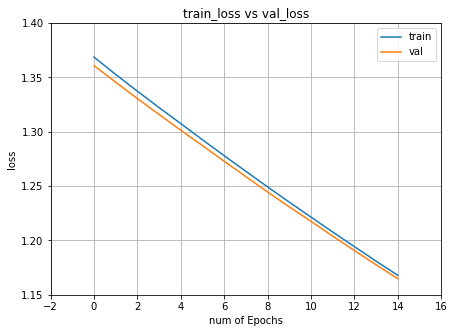

In [15]:
import matplotlib.pyplot as plt
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

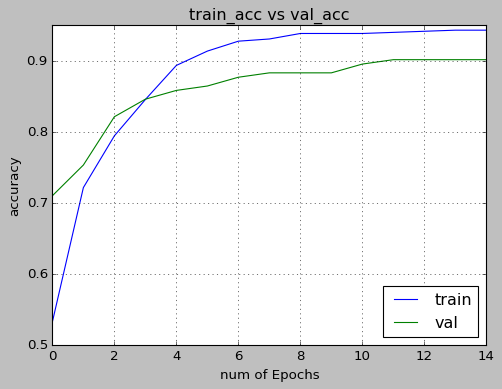

In [16]:
plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [17]:
from sklearn.metrics import accuracy_score

## Test Accuracy
predictions = custom_resnet_model.predict(X_test)
ypred = predictions > 0.5
test_acc = accuracy_score(y_test, ypred)

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

precision, recall, f1score, _ = precision_recall_fscore_support(y_test, ypred, average='weighted')

auc = roc_auc_score(y_test, ypred)

print("Train Accuracy:\t", train_acc[-1])
print("Val Accuracy:\t", val_acc[-1])
print("Test Accuracy:\t", accuracy)
print("Precision:\t", precision)
print("Recall:\t\t", recall)
print("F1 Score:\t", f1score)
print("AUC:\t\t", auc)

Train Accuracy:	 0.9427244663238525
Val Accuracy:	 0.9012345671653748
Test Accuracy:	 0.9012345671653748
Precision:	 0.0
Recall:		 0.0
F1 Score:	 0.0
AUC:		 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
# Loading the training data
PATH = os.getcwd()
# Define data path
data_path = PATH + '/data'
data_dir_list = os.listdir(data_path)

img_data_list=[]

for dataset in data_dir_list:
	img_list=os.listdir(data_path+'/'+ dataset)
	print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
	for img in img_list:
		img_path = data_path + '/'+ dataset + '/'+ img 
		img = image.load_img(img_path, target_size=(224, 224))
		x = image.img_to_array(img)
		x = np.expand_dims(x, axis=0)
		x = preprocess_input(x)
		print('Input image shape:', x.shape)
		img_data_list.append(x)

img_data = np.array(img_data_list)
#img_data = img_data.astype('float32')
print (img_data.shape)
img_data=np.rollaxis(img_data,1,0)
print (img_data.shape)
img_data=img_data[0]
print (img_data.shape)


# Define the number of classes
num_classes = 4
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:202]=0
labels[202:404]=1
labels[404:606]=2
labels[606:]=3

names = ['cats','dogs','horses','humans']
# convert class labels to on-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

###########################################################################################################################
# Custom_resnet_model_1
#Training the classifier alone
image_input = Input(shape=(224, 224, 3))


Loaded the images of dataset-cats

Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)
Input image shape: (1, 224, 2

In [20]:
# Fine tune the resnet 50
image_input = Input(shape=(224, 224, 3))

model = ResNet50(input_tensor=image_input, include_top=True,weights='imagenet')
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [24]:

from keras.layers import Dropout
last_layer = model.output
# add a global spatial average pooling layer
x = (last_layer)
# add fully-connected & dropout layers
x = Dense(512, activation='relu',name='fc-1')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu',name='fc-2')(x)
x = Dropout(0.5)(x)
# a softmax layer for 4 classes
out = Dense(num_classes, activation='softmax',name='output_layer')(x)

# this is the model we will train
custom_resnet_model2 = Model(inputs=model.input, outputs=out)

custom_resnet_model2.summary()

for layer in custom_resnet_model2.layers[:-3]:
	layer.trainable = False

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [25]:
custom_resnet_model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

t=time.time()
hist = custom_resnet_model2.fit(X_train, y_train, batch_size=32, epochs=epochs, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy) = custom_resnet_model2.evaluate(X_test, y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))


Epoch 1/15
21/21 [==============================] - 6s 159ms/step - loss: 1.2147 - accuracy: 0.7733 - val_loss: 0.6604 - val_accuracy: 0.9691
Epoch 2/15
21/21 [==============================] - 2s 116ms/step - loss: 0.5051 - accuracy: 0.9929 - val_loss: 0.2201 - val_accuracy: 0.9691
Epoch 3/15
21/21 [==============================] - 2s 115ms/step - loss: 0.1495 - accuracy: 0.9892 - val_loss: 0.1327 - val_accuracy: 0.9691
Epoch 4/15
21/21 [==============================] - 2s 115ms/step - loss: 0.0667 - accuracy: 0.9928 - val_loss: 0.1189 - val_accuracy: 0.9691
Epoch 5/15
21/21 [==============================] - 2s 116ms/step - loss: 0.0369 - accuracy: 0.9976 - val_loss: 0.1182 - val_accuracy: 0.9691
Epoch 6/15
21/21 [==============================] - 2s 116ms/step - loss: 0.0276 - accuracy: 0.9934 - val_loss: 0.1187 - val_accuracy: 0.9691
Epoch 7/15
21/21 [==============================] - 2s 116ms/step - loss: 0.0274 - accuracy: 0.9943 - val_loss: 0.1230 - val_accuracy: 0.9691
Epoch 

In [28]:

############################################################################################
import matplotlib.pyplot as plt
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(epochs)

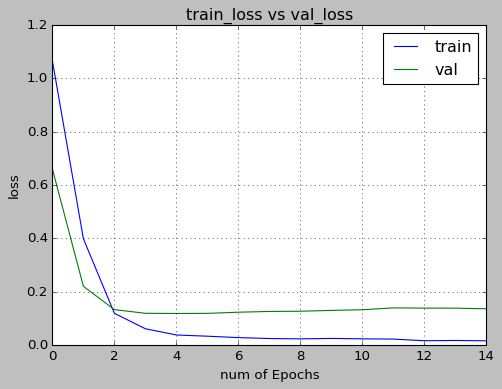

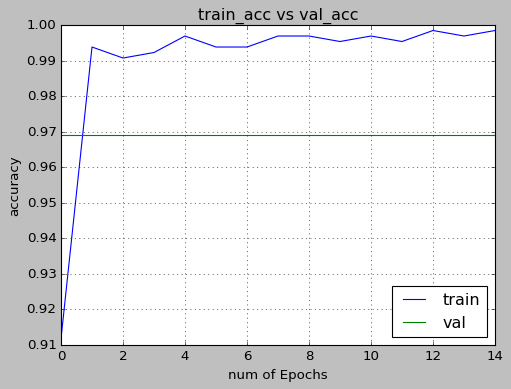

In [29]:

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [30]:
from sklearn.metrics import accuracy_score

## Test Accuracy
predictions = custom_resnet_model.predict(X_test)
ypred = predictions > 0.5
test_acc = accuracy_score(y_test, ypred)

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

precision, recall, f1score, _ = precision_recall_fscore_support(y_test, ypred, average='weighted')

auc = roc_auc_score(y_test, ypred)

print("Train Accuracy:\t", train_acc[-1])
print("Val Accuracy:\t", val_acc[-1])
print("Test Accuracy:\t", accuracy)
print("Precision:\t", precision)
print("Recall:\t\t", recall)
print("F1 Score:\t", f1score)
print("AUC:\t\t", auc)

Train Accuracy:	 0.9984520077705383
Val Accuracy:	 0.9691358208656311
Test Accuracy:	 0.9691358208656311
Precision:	 0.0
Recall:		 0.0
F1 Score:	 0.0
AUC:		 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
